Note: We downloaded and converted the dataset using another .ipynb, namely [Data Downloader IPYNB](download_data.ipynb)

In [1]:
pip freeze > requirements_training.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt

JSON_PATH = "VOC/annotations_json" #Change accordingly to your converted annotation path
BRANCH = os.listdir(JSON_PATH)
print(BRANCH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'VOC/annotations_json'

## EDA

In [2]:
records = []

for branch in os.listdir(JSON_PATH):
    path = os.path.join(JSON_PATH, branch)

    for f_name in os.listdir(path):  
        if not f_name.endswith(".json"):
            continue

        json_path = os.path.join(path, f_name)
        
        with open(json_path) as f:
            data = json.load(f)

        img_id = data["image_id"]

        img_w = data["size"]["width"]
        img_h = data["size"]["height"]
        img_area = img_w * img_h

        for obj in data["objects"]:
            c_name = obj["class"]
            diff = obj.get("difficult", 0)
            bbox = obj["bbox"]
            xmin = bbox["xmin"]
            ymin = bbox["ymin"]
            xmax = bbox["xmax"]
            ymax = bbox["ymax"]

            box_w = xmax - xmin
            box_h = ymax - ymin
            box_area = box_w * box_h

            records.append({
                "image_id": img_id,
                "class": c_name,
                "xmin": xmin,
                "ymin": ymin,
                "xmax": xmax,
                "ymax": ymax,
                "box_width": box_w,
                "box_height": box_h,
                "box_area": box_area,
                "relative_area": box_area/img_area,
                "aspect_ratio": box_w / box_h if box_h > 0 else 0,
                "difficult": diff
            })

df = pd.DataFrame(records)

In [3]:
print(len(df))

31561


In [4]:
df.head(5)

,image_id,class,xmin,ymin,xmax,ymax,box_width,box_height,box_area,relative_area,aspect_ratio,difficult
0,2008_000008,horse,53,87,471,420,418,333,139194,0.629837,1.255255,0
1,2008_000008,person,158,44,289,167,131,123,16113,0.072910,1.065041,0
2,2008_000015,bottle,270,1,378,176,108,175,18900,0.115596,0.617143,0
3,2008_000015,bottle,57,1,164,150,107,149,15943,0.097511,0.718121,0
4,2008_000019,dog,139,2,372,197,233,195,45435,0.348001,1.194872,0


In [ ]:
### Class Distribution
class_table = (
    df["class"].value_counts()
    .rename_axis("class")
    .reset_index(name="num_instances")
)

class_table["percentage"] = (
    class_table["num_instances"] / class_table["num_instances"].sum() * 100
).round(2)

class_table

,class,num_instances,percentage
0,person,10129,32.09
1,chair,2906,9.21
2,car,2364,7.49
3,dog,1541,4.88
4,bottle,1482,4.70
5,cat,1227,3.89
6,bird,1221,3.87
7,pottedplant,1099,3.48
8,boat,999,3.17
9,sheep,994,3.15


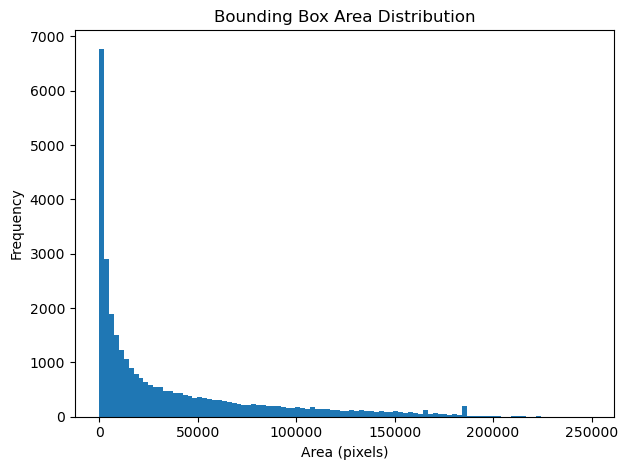

In [7]:
#Bounding Box Area Distribution
plt.figure()
plt.hist(df["box_area"], bins=100)
plt.title("Bounding Box Area Distribution")
plt.xlabel("Area (pixels)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [8]:
#Bounding Box Absolute Size Statistics
box_size_table = df[["box_width", "box_height", "box_area"]].describe().round(2)
box_size_table


,box_width,box_height,box_area
count,31561.00,31561.00,31561.00
mean,160.21,162.27,36411.66
std,136.14,115.40,45188.23
min,2.00,4.00,14.00
25%,51.00,63.00,3306.00
50%,114.00,138.00,16058.00
75%,240.00,243.00,54060.00
max,499.00,499.00,249001.00


In [9]:
#Relative Object Size
relative_area_table = (
    df["relative_area"]
    .describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9])
    .round(5)
    .to_frame(name="relative_area")
)

relative_area_table


,relative_area
count,31561.00000
mean,0.20271
std,0.24827
min,0.00008
1%,0.00089
5%,0.00258
10%,0.00507
25%,0.01851
50%,0.08979
75%,0.30254


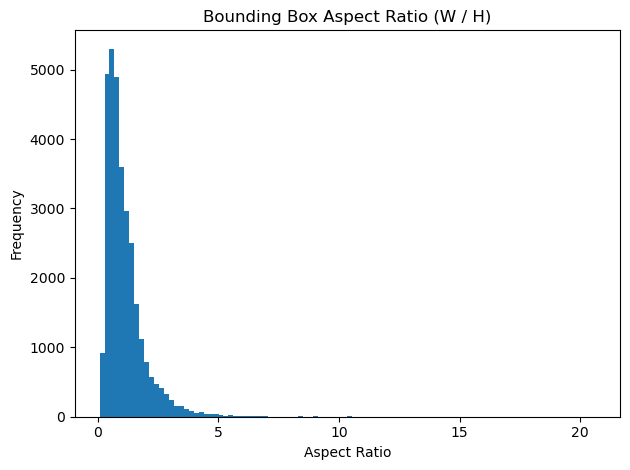

In [10]:
#Aspect Ratio Analysis
plt.figure()
plt.hist(df["aspect_ratio"], bins=100)
plt.title("Bounding Box Aspect Ratio (W / H)")
plt.xlabel("Aspect Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [11]:
#Objects per Image
objects_per_image = (
    df.groupby("image_id").size()
    .describe()
    .to_frame(name="objects_per_image")
)

objects_per_image

,objects_per_image
count,11540.000000
mean,2.734922
std,2.739746
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,56.000000


Difficult flag distribution:
difficult
0    27450
1     4111
Name: count, dtype: int64


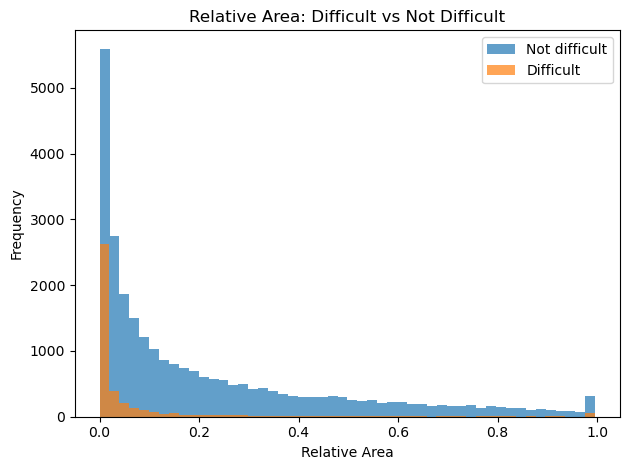

In [12]:
difficult_counts = df["difficult"].value_counts()

print("Difficult flag distribution:")
print(difficult_counts)

plt.figure()
plt.hist(
    df[df["difficult"] == 0]["relative_area"],
    bins=50,
    alpha=0.7,
    label="Not difficult"
)

plt.hist(
    df[df["difficult"] == 1]["relative_area"],
    bins=50,
    alpha=0.7,
    label="Difficult"
)

plt.legend()
plt.title("Relative Area: Difficult vs Not Difficult")
plt.xlabel("Relative Area")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Preprocessing (Filtering)

In [4]:
TARGET_CLASSES = {
    "person",
    "car",
    "bicycle",
    "bus",
    "train"
}

IMG_DIR = r"VOC\images\VOCdevkit\VOC2012\JPEGImages"
ANN_DIR = r"VOC\annotations_json\train2012"

F_IMG_DIR = "filtered_dataset/images"
F_ANN_DIR = "filtered_dataset/annotations"

MIN_REL_AREA = 0.01

# os.makedirs(F_IMG_DIR, exist_ok=True)
# os.makedirs(F_ANN_DIR, exist_ok=True)

kept_img = 0
removed_img = 0
removed_obj = 0

In [10]:
for f_n in os.listdir(ANN_DIR):
    if not f_n.endswith(".json"):
        continue

    ann_path = os.path.join(ANN_DIR, f_n)

    with open(ann_path, "r") as f:
        data = json.load(f)

    img_w = data["size"]["width"]
    img_h = data["size"]["height"]
    img_area = img_w * img_h

    filtered_objects = []
    for o in data.get("objects", []):
        c_name = o.get("class")
        diff = o.get("difficult", 0)

        if c_name not in TARGET_CLASSES or diff != 0:
            continue

        bbox = o["bbox"]
        bw = bbox["xmax"] - bbox["xmin"]
        bh = bbox["ymax"] - bbox["ymin"]
        box_area = bw * bh

        if box_area <=0:
            continue

        rel_area = box_area/img_area
        if rel_area < MIN_REL_AREA:
            removed_obj += 1
            continue

        filtered_objects.append(o)

    if len(filtered_objects) == 0:
        removed_img += 1
        continue

    data["objects"] = filtered_objects

    out_ann_path = os.path.join(F_ANN_DIR, f_n)
    with open(out_ann_path, "w") as f:
        json.dump(data, f, indent=2)

    img_name = data["image_id"] + ".jpg"
    img_dir = os.path.join(IMG_DIR, img_name)
    out_dir = os.path.join(F_IMG_DIR, img_name)

    if os.path.exists(img_dir):
        shutil.copy(img_dir, out_dir)
        kept_img += 1
    else:
        print(f"Image {img_name} not found")

print(f"Kept Images: {kept_img}")
print(f"Removed Images: {removed_img}")
print(f"Removed Objects: {removed_obj}")

Kept Images: 2658
Removed Images: 3059
Removed Objects: 845


In [13]:
#Check EDA lagi:
records = []
for f_name in os.listdir(F_ANN_DIR):  
    if not f_name.endswith(".json"):
        continue
    json_path = os.path.join(F_ANN_DIR, f_name)
    
    with open(json_path) as f:
        data = json.load(f)
    img_id = data["image_id"]
    img_w = data["size"]["width"]
    img_h = data["size"]["height"]
    img_area = img_w * img_h
    for obj in data["objects"]:
        c_name = obj["class"]
        diff = obj.get("difficult", 0)
        bbox = obj["bbox"]
        xmin = bbox["xmin"]
        ymin = bbox["ymin"]
        xmax = bbox["xmax"]
        ymax = bbox["ymax"]
        box_w = xmax - xmin
        box_h = ymax - ymin
        box_area = box_w * box_h
        records.append({
            "image_id": img_id,
            "class": c_name,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax,
            "box_width": box_w,
            "box_height": box_h,
            "box_area": box_area,
            "relative_area": box_area/img_area,
            "aspect_ratio": box_w / box_h if box_h > 0 else 0,
            "difficult": diff
        })
df = pd.DataFrame(records)

In [14]:
#Class Distribution again
class_table_filtered = (
    df["class"].value_counts()
    .rename_axis("class")
    .reset_index(name="num_instances")
)

class_table_filtered["percentage"] = (
    class_table_filtered["num_instances"] / class_table_filtered["num_instances"].sum() * 100
).round(2)

class_table_filtered

,class,num_instances,percentage
0,person,3658,68.76
1,car,743,13.97
2,bicycle,332,6.24
3,train,308,5.79
4,bus,279,5.24


In [15]:
#Objects per Image again
objects_per_image_filtered = (
    df.groupby("image_id").size()
    .describe()
    .to_frame(name="objects_per_image_filtered")
)

objects_per_image_filtered

,objects_per_image_filtered
count,2658.000000
mean,2.001505
std,1.527566
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,16.000000


In [16]:
#Bounding box size again
box_size_table_filtered = df[["box_width", "box_height", "box_area"]].describe().round(2)
box_size_table_filtered

,box_width,box_height,box_area
count,5320.00,5320.00,5320.00
mean,175.45,200.15,42127.42
std,125.58,105.52,42905.76
min,14.00,15.00,795.00
25%,76.00,110.00,8857.50
50%,137.00,190.00,26539.50
75%,244.00,275.00,60877.00
max,499.00,499.00,242015.00


## Region Proposals

### Selective Search

In [2]:
import cv2
import selectivesearch

def selective_search_gen(img, min_area = 500, max_area_ratio = 0.9):
    H, W = img.shape[:2]
    max_area = H * W * max_area_ratio

    _, regions = selectivesearch.selective_search(img, scale=500, sigma=0.9, min_size=50)
    boxes = set()

    for r in regions:
        x, y, w, h = r["rect"]
        area = w * h

        if area < min_area or area > max_area:
            continue

        boxes.add((x, y, x + w, y + h))

        return list(boxes)

In [3]:
import os, json, random
import numpy as np

IMG_DIR = "filtered_dataset/images"
ANN_DIR = "filtered_dataset/annotations"
OUT_DIR = "extract_ready_ss"

CLASSES = ["person", "car", "bicycle", "bus", "train"]

POS_IOU_TH = 0.5
NEG_IOU_TH = 0.2

MAX_POS_SAMPLE = 70
MAX_NEG_SAMPLE = 5

MIN_REGAREA = 500
MAX_REGAREA_RATIO = 0.9

random.seed(42)
np.random.seed(42)

In [7]:
os.makedirs(OUT_DIR, exist_ok=True)
for cls in CLASSES + ["background"]:
    os.makedirs(os.path.join(OUT_DIR, cls), exist_ok=True)

for ann_file in os.listdir(ANN_DIR):
    with open(os.path.join(ANN_DIR, ann_file), "r") as f:
        ann = json.load(f)

    img_path = os.path.join(IMG_DIR, ann["image_id"] + ".jpg")
    img = cv2.imread(img_path)

    if img is None:
        continue

    gt_objects = [obj for obj in ann["objects"]]
    if not gt_objects:
        continue

    p_buffer = []
    n_buffer = []

    boxes = selective_search_gen(img)
    for (x1, y1, x2, y2) in boxes:
        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        max_iou = 0
        matched = None

        for obj in gt_objects:
            gt = obj["bbox"]
            gt_box = (
                gt["xmin"], gt["ymin"],
                gt["xmax"], gt["ymax"]
            )

            iou = compute_iou((x1, y1, x2, y2), gt_box)

            if iou > max_iou:
                max_iou = iou
                matched = obj["class"]

        if max_iou >= POS_IOU_TH:
            p_buffer.append({
                "crop" : crop,
                "iou" : max_iou,
                "class" : matched
            })

        elif max_iou <= NEG_IOU_TH:
            n_buffer.append({"crop" : crop})
    
    p_buffer = sorted(p_buffer, key=lambda x: x["iou"], reverse=True)
    p_buffer = p_buffer[:MAX_POS_SAMPLE]

    if len(n_buffer) > MAX_NEG_SAMPLE:
        n_buffer = random.sample(n_buffer, MAX_NEG_SAMPLE)

    for sample in p_buffer:
        c_name = sample["class"]
        f_name = f"{ann['image_id']}_pos_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, c_name, f_name), sample["crop"])
    
    for sample in n_buffer:
        f_name = f"{ann['image_id']}_neg_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, "background", f_name), sample["crop"])

KeyboardInterrupt: 

### Image Pyramid + Sliding Windows

In [5]:
import random
import cv2
import numpy as np
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

TARGET_CLASSES = {
    "person",
    "car",
    "bicycle",
    "bus",
    "train"
}

BASE_SIZES = [96, 128, 192, 256, 512]
ASPECT_RATIO = [(1, 1), (4, 3), (3, 4), (16, 9), (9, 16)]
CLASS_ASPECT_RATIOS = {
    "person":   [(1, 2), (2, 3), (3, 4)],
    "bicycle":  [(3, 4), (1, 1), (4, 3)],
    "car":      [(4, 3), (16, 9)],
    "bus":      [(16, 9), (3, 1)],
    "train":    [(3, 1), (4, 1)],
}
STRIDE_RATIO = 0.25

PYRAMID_SCALES = [1.0, 0.75, 0.5]


POS_IOU_TH = 0.5
NEG_IOU_TH = 0.2

MAX_POS_SAMPLE = 70
MAX_NEG_SAMPLE = 5

OUT_DIR = "extract_ready_ipsw_specific"

In [3]:
def compute_iou(a, b):
    ax1, ay1, ax2, ay2 = a
    bx1, by1, bx2, by2 = b

    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)

    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih

    area_a = (ax2 - ax1) * (ay2 - ay1)
    area_b = (bx2 - bx1) * (by2 - by1)
    union = area_a + area_b - inter

    return inter / union if union > 0 else 0

In [4]:
def sliding_win(img, win_w, win_h, stride):
    H, W = img.shape[:2]
    for y in range(0, H - win_h + 1, stride):
        for x in range(0, W - win_w + 1, stride):
            yield x, y, x + win_w, y + win_h

In [13]:
os.makedirs(OUT_DIR, exist_ok=True)

for c in list(TARGET_CLASSES) + ["background"]:
    os.makedirs(os.path.join(OUT_DIR, c), exist_ok=True)

for ann_file in tqdm(os.listdir(F_ANN_DIR)):
    if not ann_file.endswith(".json"):
        continue

    with open(os.path.join(F_ANN_DIR, ann_file), "r") as f:
        ann = json.load(f)

    img_path = os.path.join(F_IMG_DIR, ann["image_id"] + ".jpg")
    img = cv2.imread(img_path)

    if img is None:
        continue


    gt_obj = [obj for obj in ann["objects"]]    
    if not gt_obj:
        continue

    p_buffer = []
    n_buffer = []
    for scale in PYRAMID_SCALES:
        resized = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        sc_h, sc_w = resized.shape[:2]

        for base in BASE_SIZES:
            for ar_w, ar_h in ASPECT_RATIO:
                win_w = int(base * ar_w/ar_h)
                win_h = int(base)

                if win_w < 32:
                    continue

                stride = int(min(win_w, win_h) * STRIDE_RATIO)

                for wx1, wy1, wx2, wy2 in sliding_win(resized, win_w, win_h, stride):
                        crop = resized[wy1:wy2, wx1:wx2]
                        if crop.size == 0:
                            continue

                        max_iou = 0
                        matched = None

                        for obj in gt_obj:
                            gt = obj["bbox"]
                            gt_scaled = (
                                int(gt["xmin"] * scale),
                                int(gt["ymin"] * scale),
                                int(gt["xmax"] * scale),
                                int(gt["ymax"] * scale),
                            )
                            iou = compute_iou((wx1, wy1, wx2, wy2), gt_scaled)

                            if iou > max_iou:
                                max_iou = iou
                                matched = obj["class"]

                        if max_iou >= POS_IOU_TH:
                            p_buffer.append({
                                "crop": crop,
                                "iou": max_iou,
                                "class": matched
                            })
                        elif max_iou <= NEG_IOU_TH:
                            n_buffer.append({
                                "crop": crop
                            })
    
    p_buffer = sorted(p_buffer, key=lambda x: x["iou"], reverse=True)
    p_buffer = p_buffer[:MAX_POS_SAMPLE]

    if len(n_buffer) > MAX_NEG_SAMPLE:
        n_buffer = random.sample(n_buffer, MAX_NEG_SAMPLE) 

    for sample in p_buffer:
        out_class = sample["class"]
        f_name = f"{ann['image_id']}_pos_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, out_class, f_name), sample["crop"])

    for sample in n_buffer:
        f_name = f"{ann['image_id']}_neg_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, "background", f_name), sample["crop"])

100%|██████████| 2658/2658 [06:45<00:00,  6.55it/s]


In [ ]:
os.makedirs(OUT_DIR, exist_ok=True)
for cls in CLASSES + ["background"]:
    os.makedirs(os.path.join(OUT_DIR, cls), exist_ok=True)

for ann_file in os.listdir(F_ANN_DIR):

    with open(os.path.join(F_ANN_DIR, ann_file)) as f:
        ann = json.load(f)

    img_path = os.path.join(IMG_DIR, ann["image_id"] + ".jpg")
    img = cv2.imread(img_path)

    if img is None:
        continue

    gt_objects = [obj for obj in ann["objects"]]

    if not gt_objects:
        continue

    pos_buffer = []
    neg_buffer = []

    for scale in PYRAMID_SCALES:
        resized = cv2.resize(img, None, fx=scale, fy=scale)

        for cls in CLASSES:
            class_gt = [o for o in gt_objects if o["class"] == cls]
            if not class_gt:
                continue

            ratios = CLASS_ASPECT_RATIOS[cls]

            for base in BASE_SIZES:
                for rw, rh in ratios:
                    win_w = int(base * rw / rh)
                    win_h = int(base)

                    if win_w < 32 or win_h < 32:
                        continue

                    stride = int(min(win_w, win_h) * STRIDE_RATIO)

                    for wx1, wy1, wx2, wy2 in sliding_win(
                        resized, win_w, win_h, stride
                    ):
                        crop = resized[wy1:wy2, wx1:wx2]
                        if crop.size == 0:
                            continue

                        max_iou = 0

                        for obj in class_gt:
                            gt = obj["bbox"]
                            gt_scaled = (
                                int(gt["xmin"] * scale),
                                int(gt["ymin"] * scale),
                                int(gt["xmax"] * scale),
                                int(gt["ymax"] * scale),
                            )

                            iou = compute_iou(
                                (wx1, wy1, wx2, wy2), gt_scaled
                            )

                            if iou > max_iou:
                                max_iou = iou

                        if max_iou >= POS_IOU_TH:
                            pos_buffer.append({
                                "crop": crop,
                                "iou": max_iou,
                                "class": cls
                            })

                        elif max_iou <= NEG_IOU_TH:
                            neg_buffer.append({
                                "crop": crop
                            })

    pos_buffer = sorted(pos_buffer, key=lambda x: x["iou"], reverse=True)
    pos_buffer = pos_buffer[:MAX_POS_SAMPLE]

    if len(neg_buffer) > MAX_NEG_SAMPLE:
        neg_buffer = random.sample(neg_buffer, MAX_NEG_SAMPLE)

    for sample in pos_buffer:
        fname = f"{ann['image_id']}_pos_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(
            os.path.join(OUT_DIR, sample["class"], fname),
            sample["crop"]
        )

    for sample in neg_buffer:
        fname = f"{ann['image_id']}_neg_{random.randint(0, 1e9)}.jpg"
        cv2.imwrite(
            os.path.join(OUT_DIR, "background", fname),
            sample["crop"]
        )


### EdgeBoxes Proposal

In [5]:
IMG_DIR = "filtered_dataset/images"
ANN_DIR = "filtered_dataset/annotations"
OUT_DIR = "extract_ready_edgebox"

CLASSES = ["person", "car", "bicycle", "bus", "train"]

POS_IOU_THRESH = 0.5
NEG_IOU_THRESH = 0.2

MAX_POS_PER_IMAGE = 30
MAX_NEG_PER_IMAGE = 120

EDGE_MODEL = "model.yml"   # structured edge model

random.seed(42)
np.random.seed(42)

In [23]:
def edgeboxes(img, max_boxes = 1000, min_score = 0.01):
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ed = cv2.ximgproc.createStructuredEdgeDetection(EDGE_MODEL)
    edges = ed.detectEdges(img.astype("float32")/255.0)
    orientation = ed.computeOrientation(edges)
    edges_nms = ed.edgesNms(edges, orientation)

    eb = cv2.ximgproc.createEdgeBoxes()
    eb.setMaxBoxes(max_boxes)
    eb.setMinScore(min_score)

    boxes, _ = eb.getBoundingBoxes(edges_nms, orientation)
    
    proposals = []
    for (x, y, w, h) in boxes:
        proposals.append((x, y, x + w, y + h))

    return proposals

In [24]:
os.makedirs(OUT_DIR, exist_ok=True)
for c_name in CLASSES + ["background"]:
    os.makedirs(os.path.join(OUT_DIR, c_name), exist_ok=True)

for ann_file in os.listdir(ANN_DIR):
    with open(os.path.join(ANN_DIR, ann_file)) as f:
        ann = json.load(f)

    img_path = os.path.join(IMG_DIR, ann["image_id"] + ".jpg")
    img = cv2.imread(img_path)

    if img is None:
        continue

    gt_objects = [obj for obj in ann["objects"]]   
    if not gt_objects:
        continue

    pos_buffer = []
    neg_buffer = []

    proposals = edgeboxes(img)
    for (x1, y1, x2, y2) in proposals:
        crop = img[y1:y2, x1:x2]
        if crop.size == 0:
            continue

        max_iou = 0
        matched = None

        for obj in gt_objects:
            gt = obj["bbox"]
            gt_box = (gt["xmin"], gt["ymin"], gt["xmax"], gt["ymax"])
            iou = compute_iou((x1, y1, x2, y2), gt_box)

            if iou > max_iou:
                max_iou = iou
                matched = obj["class"]

        if max_iou >= POS_IOU_THRESH:
            p_buffer.append({
                "crop": crop,
                "iou": max_iou,
                "class": matched
            })

        elif max_iou <= NEG_IOU_THRESH:
            n_buffer.append({
                "crop": crop
            })

    p_buffer = sorted(p_buffer, key=lambda x: x["iou"], reverse=True)
    p_buffer = p_buffer[:MAX_POS_SAMPLE]

    if len(neg_buffer) > MAX_NEG_PER_IMAGE:
        neg_buffer = random.sample(neg_buffer, MAX_NEG_PER_IMAGE)

    for sample in pos_buffer:
        c_name = sample["class"]
        f_name = f"{ann['image_id']}_pos_{random.randint(0,1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, c_name, f_name), sample["crop"])

    for sample in neg_buffer:
        f_name = f"{ann['image_id']}_neg_{random.randint(0,1e9)}.jpg"
        cv2.imwrite(os.path.join(OUT_DIR, "background", f_name), sample["crop"])

In [1]:
print(proposals)

NameError: name 'proposals' is not defined

## Feature Extraction

In [2]:
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import normalize
from tqdm import tqdm
import os, json

In [16]:
DATASET_DIR = "extract_ready_ipsw_specific"
OUT_DIR = "features"

LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS
LBP_METHOD = "uniform"
LBP_BINS = LBP_POINTS + 2
COLOR_BINS = (8, 8, 8)

IMG_SIZE = (128, 128)
HOG_PAR = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block =(2, 2),
    block_norm = "L2-Hys",
    transform_sqrt=True,
    feature_vector=True
)

# os.makedirs(OUT_DIR, exist_ok=True)
X_feats = []
Y_labels = []

In [8]:
TARGET_CLASSES = list(TARGET_CLASSES) + ["background"]

In [7]:
print(TARGET_CLASSES)

{'train', 'car', 'person', 'bicycle', 'bus'}


In [14]:
def extract_hog(gray):
    hog_vec = hog(gray, **HOG_PAR)
    # hog_vec = normalize(hog_vec.reshape(1, -1), norm="l2")[0]
    return hog_vec

def extract_lbp(gray):
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method=LBP_METHOD)
    hist, _ = np.histogram(lbp.ravel(), bins=LBP_BINS, range=(0, LBP_BINS))
    hist = hist.astype(np.float32)
    hist = hist/(hist.sum() + 1e-6)
    return hist

def extract_color(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([img_hsv], channels=[0, 1, 2], mask=None, histSize=COLOR_BINS, ranges=[0, 180, 0, 256, 0, 256])
    hist = hist.flatten().astype(np.float32)
    hist = hist/(hist.sum() + 1e-6)

    return hist

In [10]:
def extract_feat(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = extract_hog(gray)
    lbp_feat = extract_lbp(gray)
    clr_feat = extract_color(img)

    feat_vec = np.concatenate([hog_feat, lbp_feat, clr_feat])
    return feat_vec

In [17]:
for c_id, c_name in enumerate(TARGET_CLASSES):
    c_dir = os.path.join(DATASET_DIR, c_name)
    if not os.path.exists(c_dir):
        continue

    print(f"Extracting features for class: {c_name}")
    for f_name in tqdm(os.listdir(c_dir), desc=c_name):
        img_path = os.path.join(c_dir, f_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        #Extract Features
        img_rs = cv2.resize(img, IMG_SIZE)
        feat_vec = extract_feat(img_rs)
        X_feats.append(feat_vec)
        Y_labels.append(c_id)

X_features = np.array(X_feats, dtype=np.float32)
Y_labels = np.array(Y_labels, dtype=np.int64)

np.savez_compressed(
    os.path.join(OUT_DIR, "fused_features_1.npz"),
    X = X_features,
    Y = Y_labels
)

Extracting features for class: train


train: 100%|██████████| 9472/9472 [02:29<00:00, 63.56it/s]


Extracting features for class: car


car: 100%|██████████| 14848/14848 [04:04<00:00, 60.81it/s]


Extracting features for class: person


person: 100%|██████████| 12722/12722 [03:47<00:00, 56.00it/s]


Extracting features for class: bicycle


bicycle: 100%|██████████| 7883/7883 [02:30<00:00, 52.50it/s]


Extracting features for class: bus


bus: 100%|██████████| 9104/9104 [03:00<00:00, 50.34it/s]


Extracting features for class: background


background: 100%|██████████| 13290/13290 [04:25<00:00, 50.09it/s]


In [18]:
print(X_features.shape)
print(Y_labels.shape)

(67319, 8622)
(67319,)


## Train HOG-Linear SVM OvR (Inherently)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

FEAT_PATH = r"features\fused_features_1.npz"
CLASS_NAMES = [
    "person",
    "car",
    "bicycle",
    "bus",
    "train",
    "background"
]

data = np.load(FEAT_PATH)
X = data["X"]
y = data["Y"]

print(X.shape)
print(y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape[0])
print(X_test.shape[0])

scaler = StandardScaler(with_mean=False)
X_trains = scaler.fit_transform(X_train)
X_tests = scaler.transform(X_test)

(67319, 8622)
(67319,)
53855
13464


In [20]:
svm = LinearSVC(
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000
)

print("Training Linear SVM (OvR)...")
svm.fit(X_trains, Y_train)

y_pred = svm.predict(X_tests)
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Linear SVM (OvR)...
              precision    recall  f1-score   support

      person       0.74      0.78      0.76      1894
         car       0.77      0.74      0.75      2970
     bicycle       0.76      0.77      0.76      2544
         bus       0.70      0.73      0.72      1577
       train       0.81      0.82      0.81      1821
  background       0.66      0.63      0.64      2658

    accuracy                           0.74     13464
   macro avg       0.74      0.75      0.74     13464
weighted avg       0.74      0.74      0.74     13464

[[1477   93   62   44   83  135]
 [ 111 2191  154  112  102  300]
 [  77  150 1948  148   19  202]
 [  59   72  126 1159   15  146]
 [  90   99   19   17 1492  104]
 [ 176  252  242  169  134 1685]]


In [ ]:
from sklearn.svm import SVC
svm = SVC(
    kernel='linear',
    C = 0.01,
    class_weight = "balanced",
    max_iter = 5000,
    probability=True
)

print("Training Linear SVM (OvR)...")
svm.fit(X_trains, Y_train)

y_pred = svm.predict(X_tests)
print(classification_report(Y_test, y_pred, target_names=CLASS_NAMES, digits=2))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

Training Linear SVM (OvR)...


In [21]:
import joblib
import os

MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(svm, os.path.join(MODEL_DIR, "hog_svm_3f.joblib"))
joblib.dump(scaler, os.path.join(MODEL_DIR, "hog_scaler_3f.joblib"))

['models\\hog_scaler_3f.joblib']